In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
import fastai.callbacks.hooks as fch
import numpy as np
from pathlib import Path
import gc

In [3]:
path = fai.untar_data(fai.URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels')]

In [5]:
images = (path/"images").ls()
labels = (path/"labels").ls()

In [6]:
!cat {path}/valid.txt | head

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png


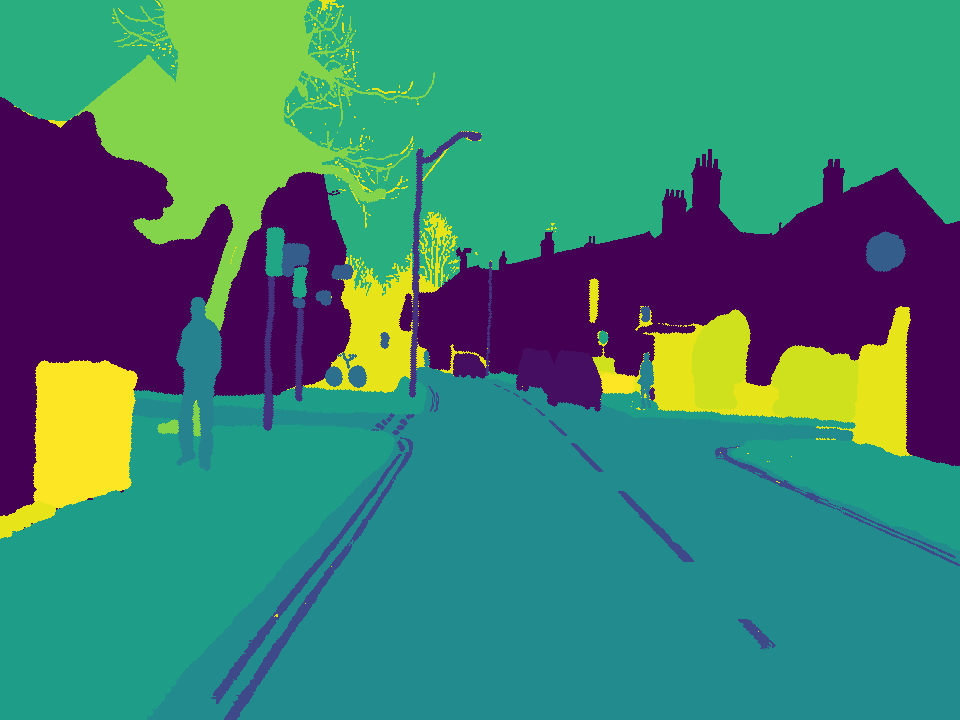

In [25]:
img_file = labels[0]
img = fv.open_mask(img_file)
img

In [9]:
def get_label(x):
    return path/'labels'/f'{x.stem}_P{x.suffix}'

In [10]:
!cat {path/'codes.txt'}

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
codes[2]

'Bicyclist'

In [13]:
size = np.array(img.shape[1:]); size

array([720, 960])

In [14]:
def load_data(img_size, batch_size):
    tfms = fv.get_transforms()
    data = (fv.SegmentationItemList
            .from_folder(path/"images")
            .split_by_fname_file(path/"valid.txt")
            .label_from_func(get_label, classes=codes)
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats))
    return data

In [15]:
data = load_data(size//2, 4)

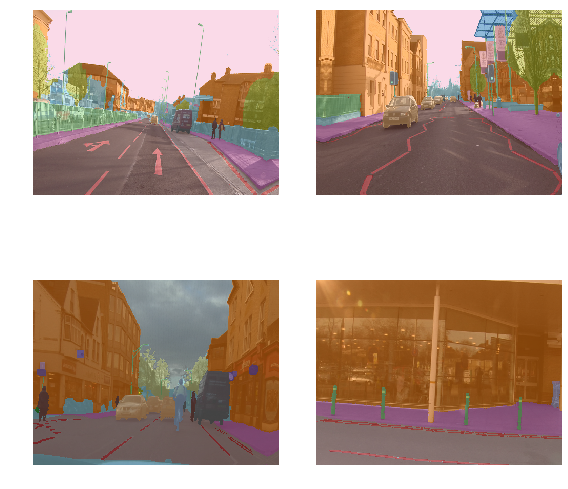

In [16]:
data.show_batch(2)

In [17]:
name2id = {v:k for k,v in enumerate(codes)}

In [18]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [19]:
void_code = name2id['Void']

In [20]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = (target != void_code)
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [21]:
learn = fv.unet_learner(data, fv.models.resnet34, metrics=acc_camvid, wd=1e-2, bottle=True)

In [ ]:
print(learn.summary())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


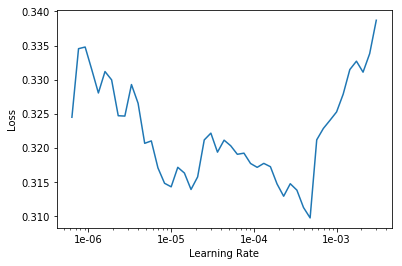

In [29]:
learn.lr_find(); learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10, slice(7e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.143556,0.844811,0.807606
2,0.777137,0.634194,0.836551
3,0.676962,0.520524,0.858898
4,0.609126,0.488978,0.866654
5,0.594800,0.474951,0.860503
6,0.587153,0.522556,0.860225
7,0.523266,0.406399,0.885299
8,0.474091,0.358222,0.897901
9,0.410814,0.352694,0.894419
10,0.339553,0.293570,0.911798


In [27]:
learn.save('first_run')

In [81]:
gc.collect()

28

In [78]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


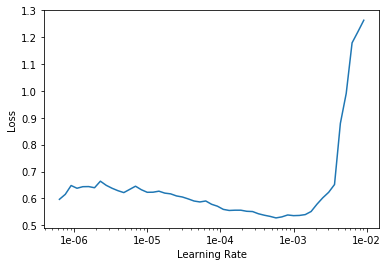

In [82]:
learn.lr_find(); learn.recorder.plot()

In [83]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.482431,0.440447,0.881879
2,0.412299,0.401616,0.891817
3,0.368290,0.363731,0.905670
4,0.332449,0.340892,0.905240
5,0.335550,0.311410,0.914345
6,0.300077,0.312734,0.914616
7,0.279389,0.345741,0.910148
8,0.284006,0.287605,0.923672
9,0.241567,0.290418,0.920404
10,0.238012,0.270754,0.926782


In [84]:
learn.save('unfrozen');

In [79]:
data = load_data(size//2, 2)

In [80]:
learn.data = data

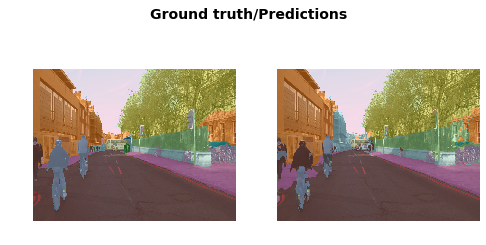

In [86]:
learn.show_results(rows=1)